# Proyecto Deep Learning

## Clasificación de imágenes médicas de tórax para predicción de Neumonía: Aplicación de DenseNet-201

- **Estudiante:** Alejandro Yáñez Oyarce
    - **Correo:** alejandro.yanez2101@alumnos.ubiobio.cl
- **Profesor:** Sebastián Espinoza Silva
    - **Correo:** sespinoza@ubiobio.cl

## Contexto

### ¿Qué es la neumonía?

La neumonía es una infección pulmonar que inflama los sacos de aire de uno o ambos pulmones, llenándolos de líquido o pus. Esto provoca síntomas como tos con flema, fiebre, escalofríos y dificultad para respirar. Diversos microorganismos, como bacterias, virus y hongos, pueden causar neumonía.

La gravedad de la neumonía varía desde leve hasta potencialmente mortal. Es más peligrosa en bebés y niños pequeños, personas mayores de 65 años y personas con sistemas inmunitarios debilitados o con problemas de salud preexistentes. [Fuente](https://www.mayoclinic.org/es/diseases-conditions/pneumonia/symptoms-causes/syc-20354204)

<center>
<img src="https://www.mayoclinic.org/-/media/kcms/gbs/patient-consumer/images/2016/05/18/13/02/ww5r032t-8col-jpg.jpg" alt="Neumonía" width="30%">
</center>

### Comparación entre Radiografías de Tórax: Pulmón Sano vs. Neumonía

En una **radiografía de tórax**, las diferencias entre un pulmón sano y uno afectado por neumonía son visualmente claras para un ojo médico y se pueden resumir en los siguientes puntos:

### 🩺 **Pulmón Sano**
- **Transparencia Pulmonar:** Los pulmones se ven **oscuros** debido a la presencia de aire, lo que indica una buena aireación.
- **Ausencia de Opacidades:** No hay zonas blancas anormales que sugieran la presencia de líquidos o pus.
- **Estructuras Definidas:** Las siluetas del corazón, diafragma y vasos sanguíneos se observan **claramente**.

### 🦠 **Pulmón con Neumonía**
- **Opacidades o Consolidaciones:** Se observan **áreas blancas o grises** en el pulmón, causadas por la acumulación de líquido o pus en los alvéolos.
- **Broncograma Aéreo:** Las vías aéreas llenas de aire aparecen como **líneas oscuras** dentro de las zonas blancas, un signo típico de neumonía.
- **Patrón de Infiltrados:** Dependiendo de la neumonía, se pueden presentar:
  - **Infiltrados Lobares:** Afectan un lóbulo completo del pulmón.
  - **Infiltrados Intersticiales:** Dispersos en el tejido pulmonar.

<center>
<img src="https://www.aboutkidshealth.ca/globalassets/assets/pneumonia_xray_medimg_pho_es.png?width=1000&quality=60" alt="Neumonía" width="50%">
</center>

[Fuente 1](https://campuskinesico.com/estudios-complementarios/elementos-para-identificar-neumonia-en-una-radiografia-de-torax/), [Fuente 2](https://www.kenhub.com/es/library/anatomia-es/radiografia-de-torax-interpretacion-paso-a-paso)

---

Cabe destacar que estás imágenes son analizadas por un médico que sabe y ha estudiado para fijarse en los detalles de ámbos pulmones. En lo personal lo único que distingo son las zonas oscuras en los pulmones afectados así que es interesante ver que tan bien puede captar estos patrones un modelo de redes neuronales como **DenseNet-201**.

## DenseNet-201

**DenseNet-201** es una **red neuronal convolucional profunda** compuesta por 201 capas, perteneciente a la familia de las **Dense Convolutional Networks (DenseNets)**.  
Introducidas en 2016 por **Gao Huang y colaboradores**, las DenseNets se distinguen por su arquitectura de **conexiones densas**, donde cada capa está conectada directamente con todas las capas posteriores en una estructura de **alimentación hacia adelante**.  

En una red convolucional tradicional con *L* capas, existen *L* conexiones, es decir, cada capa se conecta únicamente con su sucesora inmediata. En contraste, una **DenseNet** con *L* capas posee *L(L+1)/2* conexiones directas, ya que **cada capa recibe como entrada los mapas de características de todas las capas anteriores** y proporciona sus propios mapas de características a todas las capas siguientes.

DenseNet-201 ha demostrado un rendimiento notable en tareas de **clasificación de imágenes**, especialmente en conjuntos de datos como **ImageNet**, donde ha superado a muchas arquitecturas preexistentes en términos de precisión y eficiencia computacional.  
[Referencia: arXiv](https://arxiv.org/abs/1608.06993)

---


# Dataset

Para este proyecto se utilizó el siguiente [dataset](https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images/data) de *Paulo Breviglieri*, que es una versión más balanceada de imágenes entre train, test y validation del [dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) de *Paul Mooney*, ambos de *Kaggle*.

In [2]:
!kaggle datasets download 'pcbreviglieri/pneumonia-xray-images'

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
100%|█████████████████████████████████████▉| 1.14G/1.14G [00:55<00:00, 30.5MB/s]
100%|██████████████████████████████████████| 1.14G/1.14G [00:55<00:00, 22.0MB/s]


# Librerías

In [5]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

# Visualización de imágenes

## Directorios

Descomprimir el zip en una carpeta *'dataset'*.

In [3]:
folderName = 'dataset'
zipFile = 'pneumonia-xray-images.zip'

os.makedirs(folderName, exist_ok=True)

with zipfile.ZipFile(zipFile, 'r') as zipRef:
    zipRef.extractall(folderName)

print(f'{zipFile} descomprimido en {folderName}')

pneumonia-xray-images.zip descomprimido en dataset


Renombrar *'opacity'* a *'pneumonia'* para una mayor legibilidad. En el [dataset](https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images/data) de *Paulo Breviglieri* se ve que opacity se refiere a pneumonia.

In [4]:
dataPath = 'dataset'

subFolders = ['test', 'train', 'val']

for subfolder in subFolders:
    oldPath = os.path.join(dataPath, subfolder, "opacity")
    newPath = os.path.join(dataPath, subfolder, "pneumonia")

    if os.path.exists(oldPath):
        os.rename(oldPath, newPath)
        print(f"Renombrado: {oldPath} --> {newPath}")
    else:
        print(f"La carpeta {oldPath} no existe.")

Renombrado: dataset/test/opacity --> dataset/test/pneumonia
Renombrado: dataset/train/opacity --> dataset/train/pneumonia
Renombrado: dataset/val/opacity --> dataset/val/pneumonia


In [ ]:
DATA_DIR = 'dataset'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
VAL_DIR = os.path.join(DATA_DIR, 'val')

## Cantidad de imagenes en el dataset

In [ ]:
print('Train:')
numPneumonia = len(os.listdir(os.path.join(TRAIN_DIR, 'pneumonia')))
numNormal = len(os.listdir(os.path.join(TRAIN_DIR, 'normal')))
print('Cantidad de imagenes train con neumonía: ', numPneumonia)
print('Cantidad de imagenes train normales: ', numNormal)

print('\nValidation:')
print('Cantidad de imagenes test con neumonía: ', len(os.listdir(os.path.join(VAL_DIR, 'pneumonia'))))
print('Cantidad de imagenes test normales: ', len(os.listdir(os.path.join(VAL_DIR, 'normal'))))

print('\nTest:')
print('Cantidad de imagenes val con neumonía: ', len(os.listdir(os.path.join(TEST_DIR, 'pneumonia'))))
print('Cantidad de imagenes val normales: ', len(os.listdir(os.path.join(TEST_DIR, 'normal'))))

Train:
Cantidad de imagenes train con neumonía:  3110
Cantidad de imagenes train normales:  1082

Validation:
Cantidad de imagenes test con neumonía:  773
Cantidad de imagenes test normales:  267

Test:
Cantidad de imagenes val con neumonía:  390
Cantidad de imagenes val normales:  234


Se puede visualizar que el dataset está desbalanceado en el número de imágenes con neumonía, lo cual puede ser un poco problemático para la capacidad de distinguir una imagen normal.

## Imágenes con neumonía

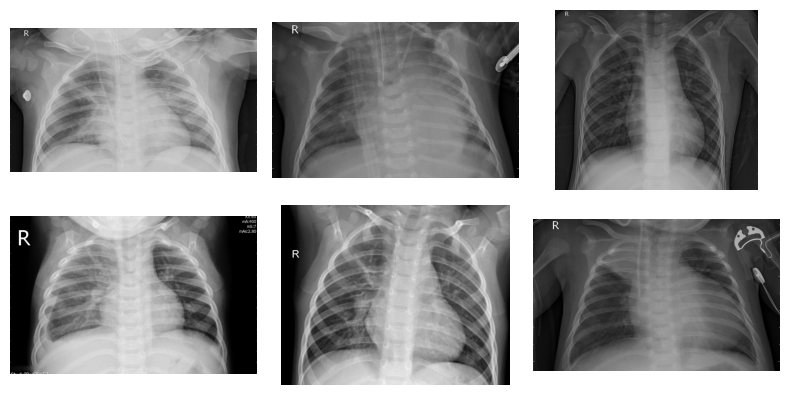

In [ ]:
NEUMONIA_DIR = os.path.join(TRAIN_DIR, 'pneumonia')
neumonia = os.listdir(NEUMONIA_DIR)

plt.figure(figsize=(8, 6))

for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(NEUMONIA_DIR, neumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

## Imágenes sin neumonía

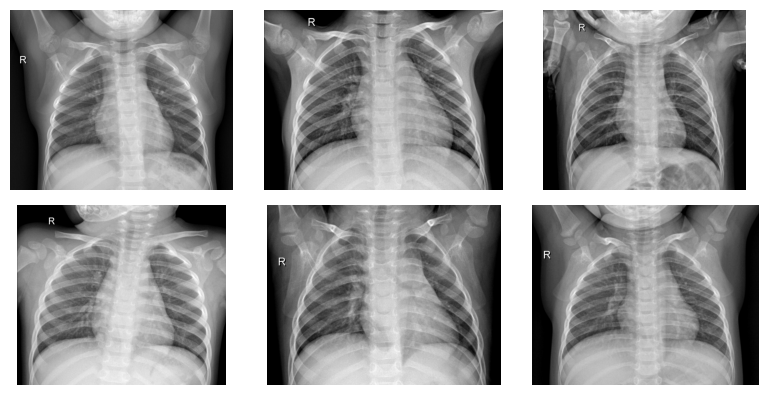

In [ ]:
NORMAL_DIR = os.path.join(TRAIN_DIR, 'normal')
normal = os.listdir(NORMAL_DIR)

plt.figure(figsize=(8, 6))

for i in range(6):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(NORMAL_DIR, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

Tal y como se dijo anteriormente, a simple vista de uno, lo único que puede ser notable entre imágenes normales y con neumonía es que en estas últimas se pueden ver algunas zonas oscuras o más grises.

## Pesos de las clases

In [ ]:
PneumoniaWeight = numPneumonia / (numPneumonia + numNormal)
NormalWeight = numNormal / (numPneumonia + numNormal)

classWeights = {0: NormalWeight, 1: PneumoniaWeight}

print('Normal weight: ', NormalWeight)
print('Pneumonia weight: ', PneumoniaWeight)

print('Class weights: ', classWeights)

Normal weight:  0.25811068702290074
Pneumonia weight:  0.7418893129770993
Class weights:  {0: 0.25811068702290074, 1: 0.7418893129770993}


Los pesos de cada clase son **inversamente proporcional a la frecuencia de la clase** por lo que sus fórmulas son:

- **Peso para la clase Normal (Clase 0):**
  $$
  W_{\text{normal}} = \frac{\text{numPneumonia}}{\text{numPneumonia} + \text{numNormal}}
  $$

- **Peso para la clase Neumonía (Clase 1):**
  $$
  W_{\text{pneumonia}} = \frac{\text{numNormal}}{\text{numPneumonia} + \text{numNormal}}
  $$

Donde:  
- $ W_{\text{normal}} $: Peso de la clase "Normal".  
- $ W_{\text{pneumonia}} $: Peso de la clase "Neumonía".  
- $ \text{numNormal} $: Cantidad de imágenes de la clase Normal.  
- $ \text{numPneumonia} $: Cantidad de imágenes de la clase Neumonía.  

Aunque no se utilizó esto más adelante, claramente se ve el desbalance de clase por los pesos.

# Preprocesamiento de imágenes

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SHUFFLE = True
VALIDATION_SPLIT = 0.3
SEED = 29

In [ ]:
imageDataGen = ImageDataGenerator(
    rescale=1./255,                 # Normaliza los valores de los pixeles
    rotation_range=30,              # Rango de grados para rotar aleatoriamente las imagenes
    zoom_range=0.2,                 # Rango de zoom aleatorio
    width_shift_range=0.2,          # Rango de traslación horizontal aleatoria
    height_shift_range=0.2,         # Rango de traslación vertical aleatoria
    brightness_range=(0.7, 1.3),    # Rango de brillo aleatorio
    horizontal_flip=True,           # Voltea aleatoriamente las imagenes horizontalmente
    fill_mode='nearest'             # Rellena los pixeles que puedan quedar vacios con los valores mas cercanos
)

trainDG = imageDataGen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,           # Tamaño de las imagenes
    batch_size=16,                  # Tamaño del batch de imagenes a procesar
    shuffle=SHUFFLE,                # Mezcla las imagenes aleatoriamente en cada epoca
    class_mode='categorical'        # Tipo de clasificación
)

validationDG = imageDataGen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,           # Tamaño de las imagenes
    batch_size=1,                   # Tamaño del batch de imagenes a procesar
    shuffle=SHUFFLE                 # Mezcla las imagenes aleatoriamente en cada epoca
)

testDG = imageDataGen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,           # Tamaño de las imagenes
    batch_size=8,                   # Tamaño del batch de imagenes a procesar
    shuffle=False,                  # No mezcla las imagenes
    class_mode='categorical'        # Tipo de clasificación
)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
images, _ = next(trainDG)
images[0].shape

(224, 224, 3)

Las imágenes son dimesionadas en 224x224 píxeles y con 3 canales (RGB) para los colores.

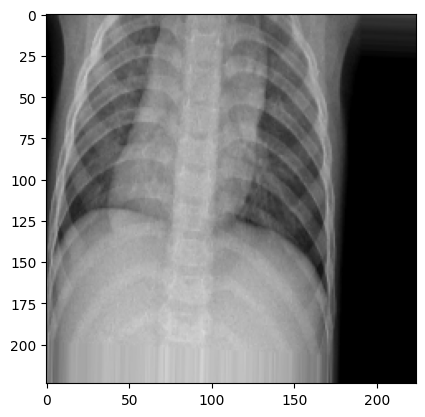

In [ ]:
images, _ = next(trainDG)
plt.imshow(images[0])

Un ejemplo de lo que viene siendo una imágen redimensionada. Personalmente no distingo si padece de neumonía o no.

In [ ]:
print(trainDG.class_indices)
print(validationDG.class_indices)
print(testDG.class_indices)

{'normal': 0, 'pneumonia': 1}
{'normal': 0, 'pneumonia': 1}
{'normal': 0, 'pneumonia': 1}


Clases que se identificaron del flow_from_directory.

# Construcción del modelo

In [ ]:
baseModel = DenseNet201(
    weights='imagenet',                             # Pesos pre-entrenados en ImageNet
    include_top=False,                              # No se incluye las capas finales
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)       # Tamaño de las imagenes
)

Se construye el modelo base con DenseNet201.

In [ ]:
baseModel.summary()

Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

Se puede ver lo grande que es el modelo, con la cantidad de parámetros totales, los entrenables y no entrenables.

## Transfer Learning

In [ ]:
def top_layer(base_model, neurons, activation):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(neurons * 3, activation=activation)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons * 1, activation=activation)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons * 2, activation=activation)(x)
    x = Dropout(0.1)(x)
    x = Dense(neurons * 1, activation=activation)(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation='softmax')(x)
    return x

Esta configuración de transfer learning se la debo a la siguiente [fuente](https://arxiv.org/pdf/2402.03347) que trata sobre un problema que requería casi la misma precisión que en este problema ya que se ocupó el modelo DenseNet-201 para la clasificación de enfermedades de hojas de papa.

Adapté la configuración a mi caso para poder adecuarse a mis previas configuraciones de clasificación categórica para dos salidas de tipo [0, 1] o [1, 0] con una **activación softmax**. También en el paper se compara el rendimiento con distintos Dropouts de 0.1 a 0.6, siendo el 0.1 con el mejor rendimiento en un balance entre entrenamiento y validación, por lo que debido a mi cómputo y tiempo no me podía permitir hacer la misma comparación, por lo tanto, confié en su investigación y ocupé 0.1 como Dropout.

In [ ]:
# Capas superiores personalizadas
top_output = top_layer(baseModel, neurons=512, activation='relu')

Se aplica las capas superiores personalizadas, con 512 neuronas en las capas densas y con **'relu'** como función de activación.

A continuación se congelan las capas del modelo base preentrenado, para poder entrenar solo las capas personalizadas.

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

model = Model(inputs=baseModel.input, outputs=top_output)

model.compile(
    optimizer='adam',                   # Optimizador
    loss='categorical_crossentropy',    # Función de pérdida
    metrics=['accuracy']                # Métrica de evaluación
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 23,110,722 (88.16 MB)

 Trainable params: 4,788,738 (18.27 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
EPOCHS = 20

earlyStopping = EarlyStopping(
    monitor='val_loss',         # Métrica a monitorear
    patience=6,                 # Número de epocas sin mejora para detener el entrenamiento
    restore_best_weights=True   # Restaurar los pesos del modelo con la mejor epoca
)

Se ocupa EarlyStopping para detener el entrenamiento cuando el modelo deje de mejorar en la métrica de pérdida en la validación. Esto es útil para prevenir el sobreajuste y optimizar el tiempo de entrenamiento.

In [ ]:
print(f'Train samples: {trainDG.samples}')
print(f'Test samples: {validationDG.samples}')
print(f'Indices en train: {trainDG.class_indices}')
print(f'Indices en test: {validationDG.class_indices}')

trainCounts = np.unique(trainDG.classes, return_counts=True)
validationCounts = np.unique(validationDG.classes, return_counts=True)

print("\nDistribución de clases en el conjunto de entrenamiento:")
for cls, count in zip(trainDG.class_indices.keys(), trainCounts[1]):
    print(f"{cls}: {count} imágenes")

print("\nDistribución de clases en el conjunto de validación:")
for cls, count in zip(validationDG.class_indices.keys(), validationCounts[1]):
    print(f"{cls}: {count} imágenes")

Train samples: 4192
Test samples: 1040
Indices en train: {'normal': 0, 'pneumonia': 1}
Indices en test: {'normal': 0, 'pneumonia': 1}

Distribución de clases en el conjunto de entrenamiento:
normal: 1082 imágenes
pneumonia: 3110 imágenes

Distribución de clases en el conjunto de validación:
normal: 267 imágenes
pneumonia: 773 imágenes


In [ ]:
history = model.fit(
    trainDG,
    epochs=EPOCHS,
    validation_data=validationDG,
    callbacks=[earlyStopping]
)

/home/aleyanez/IA/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 136s 394ms/step - accuracy: 0.8298 - loss: 0.4265 - val_accuracy: 0.9500 - val_loss: 0.1646
Epoch 2/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 337ms/step - accuracy: 0.9296 - loss: 0.1789 - val_accuracy: 0.9471 - val_loss: 0.1639
Epoch 3/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 89s 341ms/step - accuracy: 0.9433 - loss: 0.1480 - val_accuracy: 0.9433 - val_loss: 0.1547
Epoch 4/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 87s 333ms/step - accuracy: 0.9366 - loss: 0.1699 - val_accuracy: 0.9481 - val_loss: 0.1384
Epoch 5/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 89s 339ms/step - accuracy: 0.9466 - loss: 0.1431 - val_accuracy: 0.9548 - val_loss: 0.1299
Epoch 6/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 334ms/step - accuracy: 0.9451 - loss: 0.1499 - val_accuracy: 0.9077 - val_loss: 0.2105
Epoch 7/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 88s 336ms/step - accuracy: 0.9428 - loss: 0.1429 - val_accuracy: 0.9567 - val_loss: 0.2349
Epoch 8/20
262/262 ━━━━━━━━━━━━━━━━━━━━ 89s 340ms/step - accuracy: 0.9438 - loss: 

El modelo se ve que tiene muy buenos resultados en términos de accuracy tanto en entrenamiento como en validación y el sobreajuste es casi nulo. Si se puede notar en épocas específicas como entre la 6 y la 7 por la pérdida pero en general se obtuvieron buenos resultados.

Text(0.5, 1.0, 'Curva de Precisión')

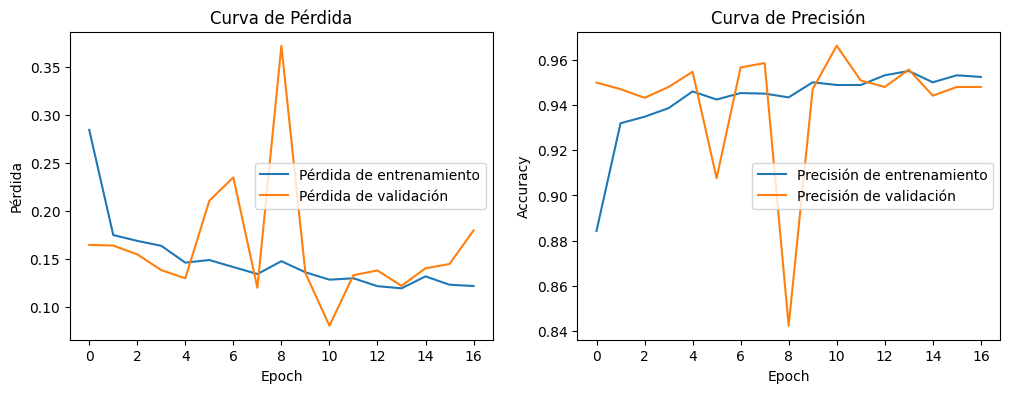

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.epoch, history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Curva de Pérdida')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.epoch, history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curva de Precisión')

- En la pérdida se puede observar que en la validación, si bien tiene buenos números en la mayoría de epochs, es algo inestable, por lo que podría deberse a un leve sobreajuste.
- En el accuracy se ven buenos números, aunque en la validación vuelve a ser algo inestable en ciertas epochs.

In [ ]:
model.evaluate(testDG)

78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.7304 - loss: 0.7039


[0.4256153702735901, 0.8381410241127014]

Se ve un muy bajo desempeño en comparación con el accuracy visto en el entrenamiento y validación, lo cual debe ser un claro sobreajuste. Si bien en el entrenamiento marcaba buenos números en accuracy para validación, esto puede deberse a que tanto los datos para entrenamiento como para validación, vienen de un mismo **'ImageDataGenerator'** por lo que pueden haber estado memorizando patrones incluso en la validación, perdiendo capacidad de generalizar ante nuevas imágenes.

In [ ]:
predictions = np.argmax(model.predict(testDG), axis=1)
print(classification_report(testDG.classes, predictions))

78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.79      0.80       624
weighted avg       0.86      0.83      0.82       624



Del reporte de clasificación se puede deducir que el desbalance de clases afectó drásticamente al rendimiento gracias a la métrica **'recall'**, ya que en la clase 1 (Neumonía) detectó casi todas las imágenes de esta clase con un 0.98 de recall mientras que en la clase 0 (Normal) se obtiene un 0.59 de recall.

In [ ]:
model.save('model.keras')

In [ ]:
testDG.reset()
y_true = testDG.classes

predictions = model.predict(testDG)
y_pred = np.argmax(predictions, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step


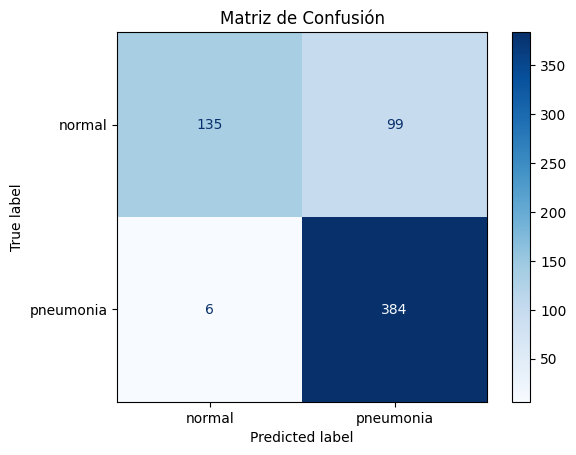

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testDG.class_indices.keys())

disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

De la matriz de confusión se puede ver como el modelo está sesgado hacia la clase dominante de neumonía, acertando en muchos más casos para neumonía que en normal.

- Se predijo correctamente 135 imágenes como "Normal".
- Se predijo que 99 imágenes tenían neumonía cuando en realidad estaban normales.
- Se predijo 6 imágenes como "Normal" cuando en realidad tenían neumonía.
- Se predijo correctamente 384 imágenes con neumonía.

# Conclusión

El modelo entrenado con **DenseNet201** muestra un desempeño desequilibrado al clasificar imágenes de radiografías de tórax con neumonía y normales. Los resultados más relevantes son los siguientes:

1. **Alta precisión en la clase "Neumonía" (Clase dominante):**
   - El modelo identifica correctamente la mayoría de las imágenes de **Neumonía**.
   - Tasa de falsos negativos: **6 casos**.

2. **Bajo desempeño en la clase "Normal":**
   - Un número significativo de imágenes "Normales" se clasifican erróneamente como "Neumonía".
   - Tasa de falsos negativos: **99 casos**.

## **Posibles Causas Principales**
- **Desbalance de clases:** La clase "Neumonía" tiene muchas más imágenes que la clase "Normal".
- **Class weights:** Aunque se calculó los pesos de las clases, no se utilizaron para el entrenamiento.

## **Posibles Mejoras**
1. **Ajustar los pesos de clase:**
   - Utilizar class_weights para dar más importancia a la clase "Normal".

2. **Fine-Tuning del modelo:**
   - Descongelar capas superiores del modelo base y aplicar un **learning rate**.

3. **Data augmentation:**
   - Aplicar **aumentaciones específicas** a la clase "Normal" para mejorar la generalización.

---

# Investigación futura

A pesar de los resultados, me gustó mucho el aplicar deep learning a casos médicos, ya que pienso puede ser una ayuda rápida y que puede servir en la realidad como una primera respuesta a casos en los que se pueden demorar mucho unos resultados de exámenes médicos. Pero antes de esto, debo intentar mejorar los resultados para que el modelo pueda tener un rendimiento balanceado para ámbas clases (normal y neumonía) aplicando técnicas que pasé por alto debido a centrarme solamente en los resultados obtenidos en el entrenamiento y validación.